In [2]:
# Install required packages
!pip install -q kagglehub tensorflow matplotlib seaborn scikit-learn

import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [1]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Set the path to your folder
# UPDATE THIS PATH to match where you put the folder in your Drive
# Example: '/content/drive/MyDrive/Datasets/Chest_CT_Scan'
path = '/content/drive/MyDrive/AI/Data'

print("Path to dataset files:", path)

# Verify the path exists
if os.path.exists(path):
    print("Folder found!")
else:
    print("Error: Folder not found. Please check the path.")

Mounted at /content/drive
Path to dataset files: /content/drive/MyDrive/AI/Data
Folder found!


In [3]:
# Search for the directory containing the split folders
dataset_root = None

for root, dirs, files in os.walk(path):
    # This specific dataset typically has 'train', 'test', and 'valid' folders
    if 'train' in dirs:
        dataset_root = root
        break

if dataset_root is None:
    dataset_root = path

train_dir = os.path.join(dataset_root, 'train')

# This dataset usually creates 'valid' or 'test'.
# We will prioritize 'valid' for validation, otherwise use 'test'.
if 'valid' in os.listdir(dataset_root):
    val_dir = os.path.join(dataset_root, 'valid')
    test_dir = os.path.join(dataset_root, 'test')
elif 'test' in os.listdir(dataset_root):
    val_dir = os.path.join(dataset_root, 'test')
    test_dir = os.path.join(dataset_root, 'test')
else:
    print("Error: Could not find validation/test folder.")

print(f"Training data located at: {train_dir}")
print(f"Validation data located at: {val_dir}")

# Verify classes
if os.path.exists(train_dir):
    detected_classes = os.listdir(train_dir)
    print(f"Classes found: {len(detected_classes)}")
    print("Classes:", detected_classes)

Training data located at: /content/drive/MyDrive/AI/Data/train
Validation data located at: /content/drive/MyDrive/AI/Data/valid
Classes found: 4
Classes: ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training Generator with Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Generator
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("Loading Training Data:")
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("\nLoading Validation Data:")
val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print(f"\nDetected Classes: {class_names}")

# --- MODEL SETUP ---

# 1. Load Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Fine-tuning
base_model.trainable = True
# Unfreeze the top 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# 3. Add Custom Head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
# Note: Dynamic number of classes based on the CT Scan folders
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Train
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)

Loading Training Data:
Found 613 images belonging to 4 classes.

Loading Validation Data:
Found 72 images belonging to 4 classes.

Detected Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.2338 - loss: 1.4710 - val_accuracy: 0.3333 - val_loss: 1.2909 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.4892 - loss: 1.1454 - val_accuracy: 0.4444 - val_loss: 1.1466 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step - accuracy: 0.5577 - loss: 0.9952 - val_accuracy: 0.4583 - val_loss: 1.0681 - learning_rate: 1.0000e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.6285 - loss: 0.8893 - val_accuracy: 0.4722 - val_loss: 0.9980 - learning_rate: 1.0000e-04
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.7017 - loss: 0.8057 - val_accuracy: 0.5694 - val_loss: 0.9488 - learning_rate: 1.0000e-04
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.6991 - loss: 0.7721 - val_accuracy: 0.5694 - val_loss: 0.9114 - learning_rate: 1.0000e-04
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.6771 - loss

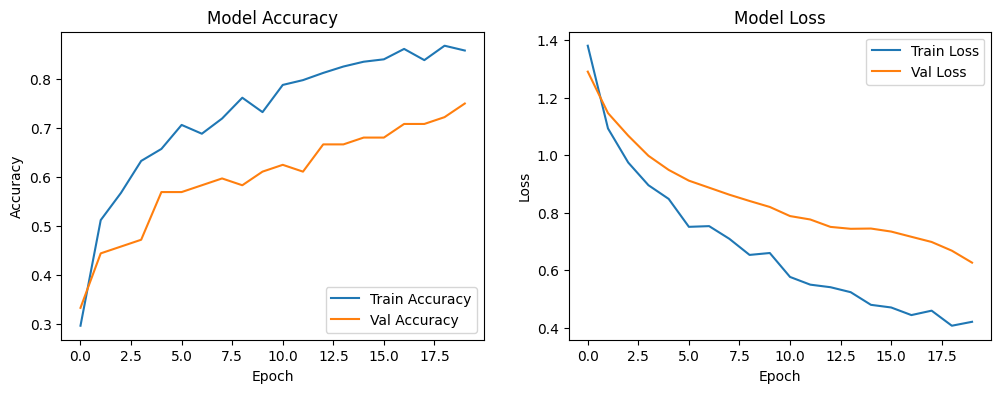

Generating predictions for Confusion Matrix...
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


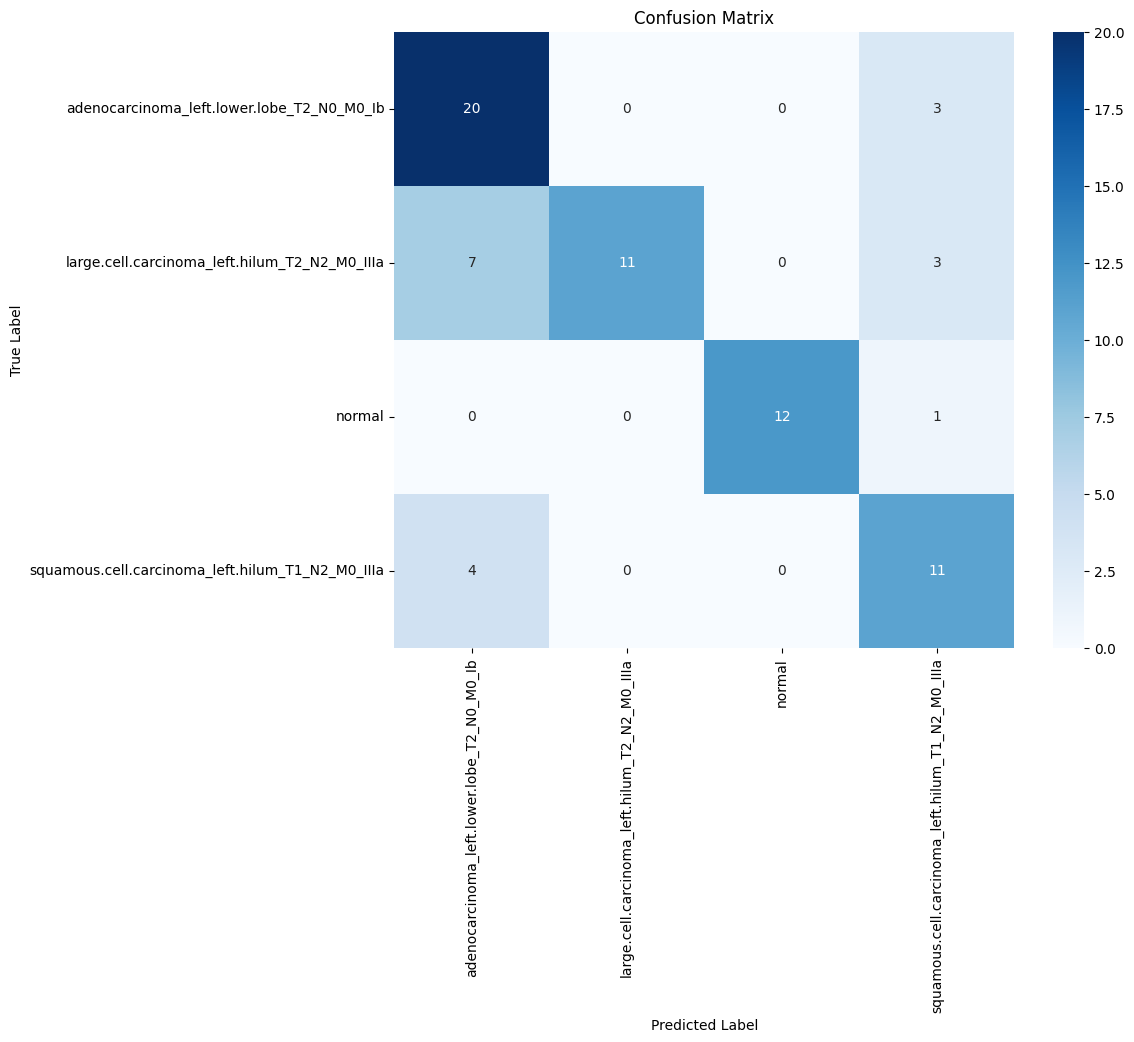


Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.65      0.87      0.74        23
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       1.00      0.52      0.69        21
                                          normal       1.00      0.92      0.96        13
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.61      0.73      0.67        15

                                        accuracy                           0.75        72
                                       macro avg       0.81      0.76      0.76        72
                                    weighted avg       0.81      0.75      0.75        72



In [7]:
# --- 1. Accuracy & Loss Graphs ---
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# --- 2. Confusion Matrix ---
# Note: We use the validation generator here for evaluation
print("Generating predictions for Confusion Matrix...")

# Reset generator to start to ensure order matches labels
val_gen.reset()

# Get predictions
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = val_gen.classes

# Generate Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Saving 000151.png to 000151.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


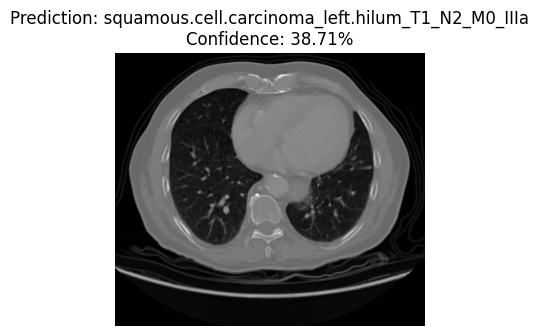

In [15]:
from google.colab import files
from tensorflow.keras.preprocessing import image

# Upload file
uploaded = files.upload()

for filename in uploaded.keys():
    # Load image with target size 224x224 (matches EfficientNet input)
    img = image.load_img(filename, target_size=(224, 224))

    # Convert to array and add batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # CRITICAL: Use specific EfficientNet preprocessing
    img_array = preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    predicted_class = class_names[predicted_index]
    confidence = np.max(predictions) * 100

    # Display Result
    plt.figure(figsize=(4, 4))
    plt.imshow(image.load_img(filename))
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.show()